In [1]:
import transformers
from transformers import XLNetTokenizer, XLNetModel
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.manifold import TSNE
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight


import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm import tqdm
from scipy.stats import spearmanr
#import mplcursors
import time
import random
import pandas as pd
import numpy as np
import warnings
import re
import json
import os


seed = 42

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

random.seed(seed)
np.random.seed(seed)


/home/macaulay/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class FineTunedBERT(nn.Module):

    def __init__(self, pool="mean", model_name= "bert-base-cased",
                 task_type = None, n_labels = None, drop_rate = None,
                 gene2vec_flag=None, gene2vec_hidden = 200):
        
        """
            task_type : regression or classification.
        
        """
      
        super(FineTunedBERT, self).__init__()
        
        assert (task_type == 'regression' and n_labels == 1) or (task_type == 'classification' and n_labels > 1), \
            f"Invalid combination of task_type and n_labels: {task_type} and {n_labels}"  
        
        assert gene2vec_flag is not None, f"gene2vec_flag cannot be None: {gene2vec_flag}"

        if "xlnet" in model_name:
            self.bert = XLNetModel.from_pretrained(model_name)
        
        else:
            self.bert = AutoModel.from_pretrained(model_name)
            
        
        
        self.pool = pool
        bert_hidden = self.bert.config.hidden_size
        
        
        if task_type.lower() == "classification":
            
            if gene2vec_flag:
                self.pipeline = nn.Sequential(
                    nn.Linear(bert_hidden+gene2vec_hidden, n_labels)
                )
                
            else:
                self.pipeline = nn.Sequential(
                    nn.Linear(bert_hidden, n_labels)
                )
            
        elif task_type.lower() == "regression":

            if gene2vec_flag:
                self.pipeline = nn.Sequential(
                nn.Linear(bert_hidden+gene2vec_hidden, 1))
                
            else:            
                self.pipeline = nn.Sequential(
                nn.Linear(bert_hidden, 1)
                )
            
        else:
            raise ValueError(f"Key Error task_type : {task_type} ")

            
        
        
    def forward(self, input_ids_, attention_mask_, gene2vec=None):
        
        
        # retrieving the hidden state embeddings
        if "xlnet" in model_name:
            output = self.bert(input_ids = input_ids_,
                               attention_mask=attention_mask_)

            hiddenState, ClsPooled = output.last_hidden_state, output.last_hidden_state[:,0, :]
            hiddenState, ClsPooled = hiddenState, ClsPooled


        else:
            hiddenState, ClsPooled = self.bert(input_ids = input_ids_,
                                               attention_mask=attention_mask_).values()

            
        # perform pooling on the hidden state embeddings
        
        if self.pool.lower() == "max":
            embeddings = self.max_pooling(hiddenState, attention_mask_)
            
        elif self.pool.lower() == "cls":
            embeddings = ClsPooled
                
        elif self.pool.lower() == "mean":
            embeddings = self.mean_pooling(hiddenState, attention_mask_)

        else:
            raise ValueError('Pooling value error.')
        
        
        if gene2vec is not None:
            embeddings = torch.cat((embeddings, gene2vec), dim=1) 
      
    
        return embeddings, hiddenState, self.pipeline(embeddings)

    def max_pooling(self, hidden_state, attention_mask):
        
        #CLS: First element of model_output contains all token embeddings
        token_embeddings = hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
        
        pooled_embeddings = torch.max(token_embeddings, 1)[0]
        return pooled_embeddings
    
    def mean_pooling (self, hidden_state, attention_mask):
        
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_state.size()).float()
        pooled_embeddings = torch.sum(hidden_state * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9) 
        
        return pooled_embeddings


In [3]:
def process_sent(sent):

    pattern1 = r'(?:"(.*?)"|\'(.*?)\')'
    pattern2 = r"\[provided by .*?\]"
    pattern3 = r"\(PubMed:\d+(?:\s+\d+)*\)"
    pattern4 = r"\(\s+[\w\s]+\s+[\w]+\s+\)"
    pattern5 = r"\s*\(Microbial infection\)"
    pattern6 = r"\[(Isoform [^\]]+)\]:\s*"
    pattern7 = r"\(By similarity\)"

    matches = re.findall(pattern1, sent)
    captured_content = [match[0] if match[0] else match[1] for match in matches]
    text = " ".join(captured_content)
    text = re.sub(pattern2, "", text)
    text = re.sub(pattern3, "####", text)
    text = re.sub(pattern4, "", text)
    text = re.sub(pattern5, "", text)
    text = re.sub(pattern6, r"\1 ", text)
    text = re.sub(pattern7, "", text)
    text = re.sub(r'\s+', ' ', text)
    
    return text
    

def getSentenceEmbeddings(sentences, max_length=512, batch_size=1000, pool ="mean"):
    
    

    model = FineTunedBERT(pool= pool)
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

    print("Perform tokenization ...")
    tokens = tokenizer.batch_encode_plus(sentences, max_length = max_length,
                                         padding="max_length",truncation=True,
                                         return_tensors="pt")
    
    
    dataset = TensorDataset(tokens["input_ids"] , tokens["attention_mask"])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    print("Tokenization Done.")
    
    print("Get embeddings ...")
    
    embeddings=[]
    model.eval()
    for batch_input_ids, batch_attention_mask in tqdm(dataloader):
        with torch.no_grad():
            pooled_embeddings, _, _ = model(batch_input_ids , batch_attention_mask)
            embeddings.append(pooled_embeddings)
    
    
    concat_embeddings = torch.cat(embeddings, dim=0)
    
    print(concat_embeddings.size())
    
    return concat_embeddings
    

In [11]:
#subcell : {0:'Cytoplasm', 1:'Nucleus', 2:'Cell membrane'}
#Sol: {0:'Membrane', 1:'Soluble'}
#cons: {0:}


def plot_latent(latents, labels, epoch, class_map = None,
                task= "subloc", validation_type="train"):
    
    tsne = TSNE(n_components=2)
    scaler = StandardScaler()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        latents_tsne = tsne.fit_transform(latents)
    

    if class_map is not None:
        
        for i, class_label in enumerate(np.unique(labels)):
            class_indices = labels == class_label
            cl = class_map[class_label]
            plt.scatter(latents_tsne[class_indices, 0],
                        latents_tsne[class_indices, 1],
                        label=f'{cl}')
        plt.legend()
        
    else:
        plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1])

        

    plt.title(f'Epoch {epoch}')
    task_path = f"saved-figures/{task}"
    if not os.path.exists(task_path):
        os.makedirs(task_path)

    validation_path = f"{task_path}/{validation_type}"
    if not os.path.exists(validation_path):
        os.makedirs(validation_path)

    plt.savefig(f"{validation_path}/latent_{epoch}.png")
    plt.close()


def train(loader, model, optimizer, task_type= None,
          gene2vec_flag = False, device = "cuda"):
    """
        task : conservation , sublocation, solubility
        task_type : regression or classification
    
    
    """
    
    train_loss = 0
    latents  = []

    total_preds = []
    total_labels = []
    
    # conservation , sublocation, solubility
    
    if task_type == "regression":
        loss_fn = nn.MSELoss()
        
    elif task_type == "classification":
        loss_fn = nn.CrossEntropyLoss()
    else:
        raise ValueError(f"task type error: {task_type}")

    
    model.train()
    for batch in tqdm(loader): 

        
        if gene2vec_flag:
            batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
            embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)
            
        else:
            batch_inputs, batch_masks , labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
            embeddings, _ , preds = model(batch_inputs, batch_masks)

        
        
        if task_type == "regression":
            
            preds = preds.squeeze().float()
            labels = labels.squeeze().float()
            
            loss = loss_fn(preds, labels)
            
            
            total_preds.extend(preds.cpu().detach())
            total_labels.extend(labels.cpu().detach())        

        
        elif task_type == "classification":
            
            loss = loss_fn(preds, labels)
            
            total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
            total_labels.extend(labels.type(torch.int).to('cpu').numpy())

        
        
        train_loss += loss.item()

        
        #Aggregation
        embeddings = torch.tensor(embeddings.cpu().detach().numpy())
        latents.append(embeddings) 
        
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(loader)
    latents = torch.cat(latents, dim=0)
                
    return model, train_loss, total_labels, total_preds, latents



def validation(loader, model, task_type = None,
                gene2vec_flag = False, device = "cuda"):
    
    val_loss = 0
    total_preds = []
    total_labels = []

    if task_type == "regression":
        loss_fn = nn.MSELoss()
        
    elif task_type == "classification":
        loss_fn = nn.CrossEntropyLoss()
    else:
        raise ValueError(f"task type error: {task_type}")

    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader): 

            if gene2vec_flag:
                batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)

            else:
                batch_inputs, batch_masks , labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks)

                
                
            if task_type == "regression":
            
                preds = preds.squeeze().float()
                labels = labels.squeeze().float()

                loss = loss_fn(preds, labels)


                total_preds.extend(preds.cpu().detach())
                total_labels.extend(labels.cpu().detach())        

        
            elif task_type == "classification":

                loss = loss_fn(preds, labels)

                total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
                total_labels.extend(labels.type(torch.int).to('cpu').numpy())


            
            val_loss += loss.item()
                

    val_loss /= len(loader)

    return model, val_loss, total_labels, total_preds


def test(loader, model, task_type = None, gene2vec_flag = False, device = "cuda"):
    
    test_loss = 0
    total_preds = []
    total_labels = []
    latents = []

    
    if task_type == "regression":
        loss_fn = nn.MSELoss()
        
    elif task_type == "classification":
        loss_fn = nn.CrossEntropyLoss()
    else:
        raise ValueError(f"task type errot: {task_type}")
    
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader): 

            if gene2vec_flag:
                batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)

            else:
                batch_inputs, batch_masks, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks)      
            
            
            if task_type == "regression":
            
                preds = preds.squeeze().float()
                labels = labels.squeeze().float()

                loss = loss_fn(preds, labels)


                total_preds.extend(preds.cpu().detach())
                total_labels.extend(labels.cpu().detach())        

        
            elif task_type == "classification":

                loss = loss_fn(preds, labels)

                total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
                total_labels.extend(labels.type(torch.int).to('cpu').numpy())

            
            test_loss += loss.item()
            

            embeddings = torch.tensor(embeddings.cpu().detach().numpy())
            latents.append(embeddings)

    test_loss /= len(loader)
    latents = torch.cat(latents, dim=0)

                
    return model, test_loss, total_labels, total_preds, latents

def process_data(genes, max_length, batch_size, val_genes = None , test_genes = None, 
                 task_type = "classification", gene2vec_flag = False,
                 model_name= "bert-base-cased"):
    
    
    if "xlnet" in model_name:
        tokenizer = XLNetTokenizer.from_pretrained(model_name)

    else:    
        tokenizer = BertTokenizerFast.from_pretrained(model_name)

    
    
    sentences, labels = genes["Summary"].tolist() , genes["Label"].tolist()
    g_index, g_name = genes.index.tolist() , genes["Gene name"].tolist()
    
            

    tokens = tokenizer.batch_encode_plus(sentences, max_length = max_length,
                                         padding="max_length", truncation=True)

    data = {'input_ids': tokens["input_ids"],
            'token_type_ids': tokens["token_type_ids"],
            'attention_mask': tokens["attention_mask"],
            "labels": labels,
            "g_index": g_index,
            "g_name": g_name
           }
    
    tokens_df = pd.DataFrame(data)
    print(f"Shape of tokens_df before gene2vec:{tokens_df.shape}")
    
    #############################################
    if gene2vec_flag:
        print("Adding Gene2Vec data ...")
        
        Gene2Vec = dict()

        file_path = f'data/gene2vec_embeddings.txt'
        with open(file_path, 'r') as file:
            for line in file:

                name, embed = line.strip().split("	")
                embed = [float(value) for value in embed.split()] 

                Gene2Vec[name.strip()] = embed
                    
            
        tokens_df = tokens_df[tokens_df['g_name'].isin(set(Gene2Vec.keys()) & set(tokens_df["g_name"]))]
        
        tokens_df["gene2vec"] = tokens_df["g_name"].apply(lambda name: 
                                                          Gene2Vec[name])# if name in Gene2Vec.keys() else None )
    
    #############################################
    print(f"Shape of tokens_df after gene2vec:{tokens_df.shape}")
    
    #val_genes, test_genes,
    

    if val_genes is not None:
        val_tokens = tokens_df.loc[val_genes]
        test_tokens =  tokens_df.loc[test_genes]
        train_tokens = tokens_df.drop(val_genes+test_genes)
        
    else:
        train_tokens, test_tokens = train_test_split(tokens_df, test_size=0.15,
                                                     random_state=42)

        train_tokens, val_tokens = train_test_split(train_tokens,test_size=0.20,
                                                    random_state=42)

    

    train_tokens = train_tokens.reset_index(drop=True)
    val_tokens = val_tokens.reset_index(drop=True)
    test_tokens = test_tokens.reset_index(drop=True)
    
    if gene2vec_flag:
    
        train_dataset = TensorDataset(torch.tensor(train_tokens["input_ids"].tolist()),
                                      torch.tensor(train_tokens["attention_mask"].tolist()),
                                      torch.tensor(train_tokens["gene2vec"]),
                                      torch.tensor(train_tokens["labels"]),
                                      torch.tensor(train_tokens["g_index"]))
        
        val_dataset = TensorDataset(torch.tensor(val_tokens["input_ids"].tolist()) ,
                            torch.tensor(val_tokens["attention_mask"].tolist()),
                            torch.tensor(val_tokens["gene2vec"]),
                            torch.tensor(val_tokens["labels"]),
                            torch.tensor(val_tokens["g_index"]))
        
        test_dataset = TensorDataset(torch.tensor(test_tokens["input_ids"].tolist()),
                             torch.tensor(test_tokens["attention_mask"].tolist()),
                             torch.tensor(test_tokens["gene2vec"]),
                             torch.tensor(test_tokens["labels"]),
                             torch.tensor(test_tokens["g_index"]))
    else:
        train_dataset = TensorDataset(torch.tensor(train_tokens["input_ids"].tolist()),
                                      torch.tensor(train_tokens["attention_mask"].tolist()),
                                      torch.tensor(train_tokens["labels"]),
                                      torch.tensor(train_tokens["g_index"]))
        
        val_dataset = TensorDataset(torch.tensor(val_tokens["input_ids"].tolist()) ,
                            torch.tensor(val_tokens["attention_mask"].tolist()),
                            torch.tensor(val_tokens["labels"]),
                            torch.tensor(val_tokens["g_index"]))
        
        test_dataset = TensorDataset(torch.tensor(test_tokens["input_ids"].tolist()),
                             torch.tensor(test_tokens["attention_mask"].tolist()),
                             torch.tensor(test_tokens["labels"]),
                             torch.tensor(test_tokens["g_index"]))
        
        
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    return train_loader, val_loader, test_loader



def get_metrics(y_true , y_pred, history,  val_type = "Train", task_type = "classification"):
    
    
    if task_type == "classification":
    
        acc= accuracy_score(y_true , y_pred)
        f1 = f1_score(y_true , y_pred, average='weighted')
        prec = precision_score(y_true , y_pred, average='weighted')
        rec = recall_score(y_true , y_pred, average='weighted')

        history[val_type]["Accuracy"].append(acc)
        history[val_type]["F1"].append(f1)
        history[val_type]["Precision"].append(prec)
        history[val_type]["Recall"].append(rec)
        
        return acc, f1 , prec , rec
        
    else:
        
        corrcoef = spearmanr(y_true, y_pred)[0]
        history[val_type]["Correlation"].append(corrcoef)
        
        return corrcoef
    



def trainer(epochs, genes, train_loader, val_loader, test_loader,
                lr = 1e-5, pool = "cls", max_length= 100, batch_size =100, drop_rate =0.1,
                gene2vec_flag = None, gene2vec_hidden = 200, device = "cuda",
                task_type = "classification", n_labels = 3 , model_name= "bert-base-cased", task_name = 'Subcellular_location'):
    
    
    """
        gene2vec_flag: if True then, the embeddings of gene2vec will be concat to GeneLLM embeddings.

        model_name: "xlnet-base-cased",
                    "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract",
                    "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
                    "dmis-lab/biobert-base-cased-v1.1",
                    "bert-base-cased",
                    "bert-base-uncased"


        task_type = classification or regression
    
    
    """
    
    

    #subcell : {0:'Cytoplasm', 1:'Nucleus', 2:'Cell membrane'}
    #Sol: {0:'Membrane', 1:'Soluble'}
    #cons: {0:}
    global class_map
    if task_type == "classification":
        history = {
            "Train":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[]},
            "Val":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[]},
            "Test":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[]}}
        
        unique_values = genes.iloc[:, 3].unique()
        
        class_map = {i: value for i, value in enumerate(unique_values)}
        print ("\n#############################")
        print (f"Currently running {task_name}.")
        print ("#############################\n")


               
    elif task_type == "regression":
        history = {
            "Train":{"Correlation":[]}, "Val":{"Correlation":[]}, "Test":{"Correlation":[]}}
        
        if n_labels == 1:
            
            class_map = None
            print ("\n###############################")
            print (f"Currently running {task_name}.")
            print ("###############################\n")
        
    
    model = FineTunedBERT(pool= pool, task_type = task_type, n_labels = n_labels,
                          drop_rate = drop_rate, model_name = model_name,
                          gene2vec_flag= gene2vec_flag,
                          gene2vec_hidden = gene2vec_hidden).to(device)
    
    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    
#     train_loader, val_loader, test_loader = process_data_sub(genes, max_length, batch_size,
#                                                              gene2vec_flag = gene2vec_flag,
#                                                              model_name = model_name)
    
    best_pred = None
    optimal_acc = -1
    
    
    for epoch in range(epochs):
        start_time = time.time()
        
        print(f"Epoch {epoch+1} of {epochs}")
        print("-------------------------------")
        
        print("Training ...")
        
        model, train_loss, labels_train, pred_train, latents = train(train_loader, model, optimizer,
                                                                     task_type = task_type,
                                                                     gene2vec_flag = gene2vec_flag,
                                                                     device = device)
        
        plot_latent(latents, labels_train,  epoch, class_map, task_name, validation_type="train")
        
        
        
        print("Validation ...")
        model, val_loss, labels_val, pred_val  = validation (val_loader, model,
                                                             task_type = task_type,
                                                             gene2vec_flag = gene2vec_flag,
                                                             device = device)
        
        print("Testing ...")
        model, test_loss, labels_test, pred_test, _ = test (test_loader, model,
                                                            task_type = task_type,
                                                            gene2vec_flag = gene2vec_flag,
                                                           device = device)
        

        metrics_train  = get_metrics(labels_train , pred_train, history,
                                      val_type = "Train", task_type = task_type)
        
        metrics_val = get_metrics(labels_val , pred_val, history,
                                  val_type = "Val",task_type = task_type)

        metrics_test = get_metrics(labels_test , pred_test, history, val_type = "Test",
                                   task_type = task_type)

        if task_type == "classification":
            acc_train, f1_train, prec_train, rec_train = metrics_train
            acc_val, f1_val, prec_val, rec_val = metrics_val
            acc_test, f1_test, prec_test, rec_test = metrics_test

            print(f'\tET: {round(time.time() - start_time,2)} Seconds')
            print(f'Train Loss: {round(train_loss,4)}, Accuracy: {round(acc_train,4)}, F1: {round(f1_train,4)}, Precision: {round(prec_train,4)}, Recall: {round(rec_train,4)}')
            print(f'Val Loss: {round(val_loss,4)}, Accuracy: {round(acc_val,4)}, F1: {round(f1_val,4)}, Precision: {round(prec_val,4)}, Recall: {round(rec_val,4)}')
            print(f'Test Loss: {round(test_loss,4)}, Accuracy: {round(acc_test,4)}, F1: {round(f1_test,4)}, Precision: {round(prec_test,4)}, Recall: {round(rec_test,4)}')
    
        else:
            
            train_corr = metrics_train
            val_corr = metrics_val
            test_corr = metrics_test
            
            print(f'\tET: {round(time.time() - start_time,2)} Seconds')
            print(f'\tTrain Loss: {round(train_loss,4)}, corrcoef: {round(train_corr,4)}')
            print(f'\tVal Loss: {round(val_loss,4)}, corrcoef: {round(val_corr,4)}')
            print(f'\tTest Loss: {round(test_loss,4)}, corrcoef: {round(test_corr,4)}')

            
#     return history, labels_test, best_pred


def loading_data(input_data_path = 'data/subcellular_location.csv', task_type = "classification"):

    knownGenes = []
    for i in range (14):
        file_path = f'data/knownGenes/GeneLLM_all_cluster{i}.txt'
        with open(file_path, 'r') as file:
            for line in file:
                knownGenes.append(line.strip()) 


    input_data = pd.read_csv(input_data_path)
    gene_name = input_data.columns[0]
    global task_name
    task_name = input_data.columns[1]
    labels_dict = input_data.set_index(gene_name)[task_name].to_dict()


    genes = pd.read_csv("data/genes.csv")
    genes["Summary"] = genes["Summary"].apply(lambda sent: process_sent(sent))
    genes = genes.drop_duplicates(subset='Summary')
    genes = genes[genes['Gene name'].isin(knownGenes)]

    if task_type == "classification":

        genes[task_name] = genes["Gene name"].apply(lambda name: labels_dict.get(name,None))

        genes_loc = genes.dropna(subset=[task_name]).reset_index(drop=True)

        labels, uniques = pd.factorize(genes_loc[task_name])
        label_dict = dict(zip(uniques, range(len(uniques))))
        n_labels = len(uniques)
        

        genes_loc["Label"] = genes_loc[task_name].map(label_dict)

        #print(genes_loc.Label.value_counts())
    
        return genes_loc, n_labels

    elif task_type == "regression":
        genes["Label"] = genes["Gene name"].apply(lambda name: labels_dict.get(name,None))
        genes_phast = genes.dropna(subset=["Label"]).reset_index(drop=True)
        n_labels = 1

        return genes_phast, n_labels

# Conservation 

### Load data

In [13]:

input_data_path = 'data/phastcons.csv'
task_type = "regression"

gene_loaded_data, n_labels = loading_data(input_data_path, task_type)
print(f'Number of {task_name} labels: {n_labels}')
display(gene_loaded_data)





epochs =6
lr = 1e-5
pool ="cls"
max_length = 5
batch_size = 1000
drop_rate = 0.1
gene2vec_hidden = 200
gene2vec_flag = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task_type = task_type
n_labels = n_labels
task_name = task_name

model_name= "bert-base-cased"

train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size,
                                                     gene2vec_flag = gene2vec_flag,
                                                     model_name = model_name)

trainer(epochs, gene_loaded_data, train_loader, val_loader, test_loader,
            lr =lr, pool= pool, max_length= max_length, batch_size = batch_size, drop_rate =drop_rate,
            gene2vec_flag = gene2vec_flag, gene2vec_hidden = gene2vec_hidden, device = device,
            task_type = task_type, n_labels = n_labels, model_name= model_name, task_name = task_name)


Number of Conservation labels: 1


,Gene name,Summary,Interactions,Label
0,FES,This gene encodes the human cellular counterpa...,Homooligomer.Interacts with BCR.Interacts (whe...,0.640952
1,SLC7A7,The protein encoded by this gene is the light ...,NaN,0.418753
2,HSPA2,Enables disordered domain specific binding act...,NaN,0.424108
3,ZSCAN9,Enables sequence-specific double-stranded DNA ...,NaN,0.090192
4,SEPTIN3,This gene encodes a member of the sorting nexi...,Interacts with ATP6V1D; may play a role in cil...,0.703949
...,...,...,...,...
14512,C19orf25,This gene encodes a T-box family member. The T...,The sequence AAD21787.1 differs from that show...,0.160615
14513,IQCJ-SCHIP1,C19orf25 (Chromosome 19 Open Reading Frame 25)...,NaN,0.668076
14514,BPY2C,This gene is located in the nonrecombining por...,Interacts with MAP1S.Interacts with UBE3A (via...,0.066946
14515,DNER,The protein encoded by this gene is a cofactor...,Forms a 1:1 stoichiometric complex with pancre...,0.662750


Shape of tokens_df before gene2vec:(14517, 6)
Shape of tokens_df after gene2vec:(14517, 6)

###############################
Currently running Conservation.
###############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.37it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.61it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.50it/s]


	ET: 14.85 Seconds
	Train Loss: 0.1929, corrcoef: 0.0191
	Val Loss: 0.0494, corrcoef: 0.1169
	Test Loss: 0.0486, corrcoef: 0.1237
Epoch 2 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.66it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.76it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.11it/s]


	ET: 15.32 Seconds
	Train Loss: 0.0521, corrcoef: 0.085
	Val Loss: 0.0467, corrcoef: 0.0614
	Test Loss: 0.0462, corrcoef: 0.0571
Epoch 3 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.66it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.29it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.17it/s]


	ET: 16.37 Seconds
	Train Loss: 0.0448, corrcoef: 0.0471
	Val Loss: 0.0412, corrcoef: 0.1538
	Test Loss: 0.0407, corrcoef: 0.1635
Epoch 4 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.20it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.39it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.44it/s]


	ET: 15.42 Seconds
	Train Loss: 0.0412, corrcoef: 0.1438
	Val Loss: 0.0408, corrcoef: 0.1632
	Test Loss: 0.04, corrcoef: 0.1688
Epoch 5 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.65it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.09it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.39it/s]


	ET: 15.33 Seconds
	Train Loss: 0.0406, corrcoef: 0.1555
	Val Loss: 0.0406, corrcoef: 0.1538
	Test Loss: 0.0399, corrcoef: 0.1514
Epoch 6 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.27it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.92it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.89it/s]


	ET: 17.1 Seconds
	Train Loss: 0.0403, corrcoef: 0.1634
	Val Loss: 0.0404, corrcoef: 0.1667
	Test Loss: 0.0397, corrcoef: 0.1876


### Conservation plot

In [ ]:
val_type = "train"
task = task_name
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/{task}/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

### Conservation plot Esemble

In [ ]:
with open("data/val_test_split.json", 'r') as json_file:
    dict_split = json.load(json_file)

val_genes = dict_split["val"]
test_genes = dict_split["test"]
final_preds = {ind:{0:0,1:0,2:0} for ind in test_genes}

names = ["xlnet-base-cased",
        "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract",
        "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
        "dmis-lab/biobert-base-cased-v1.1",
        "bert-base-cased",
         "bert-base-uncased"
]



epochs = 5
lr = 1e-5
max_length = 512
batch_size = 20
pool ="cls"
drop_rate = 0.1
gene2vec_hidden = 200
device = "cuda"
class_map = class_map



for model_name in names:
    for gene2vec_flag in [True, False]:
        
        print(f"model :{model_name}, gene2vec: {gene2vec_flag}")
        
        if gene2vec_flag:
            task="sub_gene2vec"
        else:
            task="class"
        
        train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size,
                                                                 val_genes, test_genes,
                                                                 gene2vec_flag = gene2vec_flag,
                                                                 model_name = model_name)

        history, labels_test, best_pred = trainer(
                                                    epochs, gene_loaded_data, train_loader, val_loader, test_loader,
                                                    lr=lr, pool=pool, max_length=max_length, drop_rate=drop_rate,
                                                    gene2vec_flag=gene2vec_flag, gene2vec_hidden=gene2vec_hidden,
                                                    device=device, task_type=task_type, model_name=model_name,
                                                    task_name=task_name
                                                    )
        
        if gene2vec_flag:
            ind = test_loader.dataset.tensors[4]
        else:
            ind = test_loader.dataset.tensors[3]
            
            
        for i, pred in zip(ind, best_pred):
            final_preds[int(i)][int(pred)] += 1
        
with open("data/ensemble_preds_cls.json", 'w') as json_file:
    json.dump(final_preds, json_file)

labels_test2 = [int(i) for i in labels_test]
with open("data/true_labels_cls.json", 'w') as json_file:
    json.dump(labels_test2, json_file)



## Conservation Mean

In [ ]:

# Perform Majority Voting
y_pred = []
y_true = labels_test
for id_, class_counts in final_preds.items():
    majority_class = max(class_counts, key=class_counts.get)
    y_pred.append(majority_class)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')

print(f' Accuracy: {round(acc,4)}\n F1: {round(f1,4)}\n Precision: {round(prec,4)}\n Recall: {round(rec,4)}')
    

## Conservation CLS

In [ ]:

with open("data/ensemble_preds_cls.json") as json_file:
    final_preds = json.load(json_file)

with open("data/true_labels_cls.json") as json_file:
    labels_test = json.load(json_file)

y_pred = []
y_true = labels_test
for id_, class_counts in final_preds.items():
    majority_class = max(class_counts, key=class_counts.get)
    y_pred.append(int(majority_class))

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')

print(f' Accuracy: {round(acc,4)}\n F1: {round(f1,4)}\n Precision: {round(prec,4)}\n Recall: {round(rec,4)}')
    
    

# Subcellular Locations

### Load data

## Model: $GeneLLM_{tuned}$ 

In [14]:

input_data_path = 'data/subcellular_location.csv'
task_type = "classification"

gene_loaded_data, n_labels = loading_data(input_data_path, task_type)
print(f'Number of {task_name} labels: {n_labels}')
display(gene_loaded_data)





epochs =6
lr = 1e-5
pool ="cls"
max_length = 5
batch_size = 1000
drop_rate = 0.1
gene2vec_hidden = 200
gene2vec_flag = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task_type = task_type
n_labels = n_labels
task_name = task_name

model_name= "bert-base-cased"

train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size,
                                                     gene2vec_flag = gene2vec_flag,
                                                     model_name = model_name)

trainer(epochs, gene_loaded_data, train_loader, val_loader, test_loader,
            lr =lr, pool= pool, max_length= max_length, batch_size = batch_size, drop_rate =drop_rate,
            gene2vec_flag = gene2vec_flag, gene2vec_hidden = gene2vec_hidden, device = device,
            task_type = task_type, n_labels = n_labels, model_name= model_name, task_name = task_name)


Number of Subcellular_location labels: 3


,Gene name,Summary,Interactions,Subcellular_location,Label
0,FES,This gene encodes the human cellular counterpa...,Homooligomer.Interacts with BCR.Interacts (whe...,Cytoplasm,0
1,HSPA2,Enables disordered domain specific binding act...,NaN,Cytoplasm,0
2,ZSCAN9,Enables sequence-specific double-stranded DNA ...,NaN,Nucleus,1
3,SEPTIN3,This gene encodes a member of the sorting nexi...,Interacts with ATP6V1D; may play a role in cil...,Cytoplasm,0
4,TBC1D25,This gene encodes an endothelial cell-to-cell ...,The sequence BAA95986.2 differs from that show...,Cytoplasm,0
...,...,...,...,...,...
8569,RALBP1,RALBP1 plays a role in receptor-mediated endoc...,NaN,Cell membrane,2
8570,OR4D6,This gene encodes a protein that belongs to th...,Interacts with PRDM8.,Cell membrane,2
8571,TBX20,Olfactory receptors interact with odorant mole...,NaN,Nucleus,1
8572,DNER,The protein encoded by this gene is a cofactor...,Forms a 1:1 stoichiometric complex with pancre...,Cell membrane,2


Shape of tokens_df before gene2vec:(8574, 6)
Shape of tokens_df after gene2vec:(8574, 6)

#############################
Currently running Subcellular_location.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.10it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.08it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.50it/s]


	ET: 8.84 Seconds
Train Loss: 1.0861, Accuracy: 0.4045, F1: 0.2755, Precision: 0.4687, Recall: 0.4045
Val Loss: 1.0341, Accuracy: 0.4266, F1: 0.3671, Precision: 0.4621, Recall: 0.4266
Test Loss: 1.0347, Accuracy: 0.4351, F1: 0.3808, Precision: 0.5104, Recall: 0.4351
Epoch 2 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.81it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.21it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.56it/s]


	ET: 8.61 Seconds
Train Loss: 1.0296, Accuracy: 0.4411, F1: 0.4079, Precision: 0.4954, Recall: 0.4411
Val Loss: 1.0268, Accuracy: 0.4499, F1: 0.4224, Precision: 0.5324, Recall: 0.4499
Test Loss: 1.0236, Accuracy: 0.4709, F1: 0.4391, Precision: 0.5712, Recall: 0.4709
Epoch 3 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.77it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.69it/s]


Testing ...


 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1/2 [00:00<00:00, 10.80it/s]


KeyboardInterrupt: 

## Subcellular Location plot

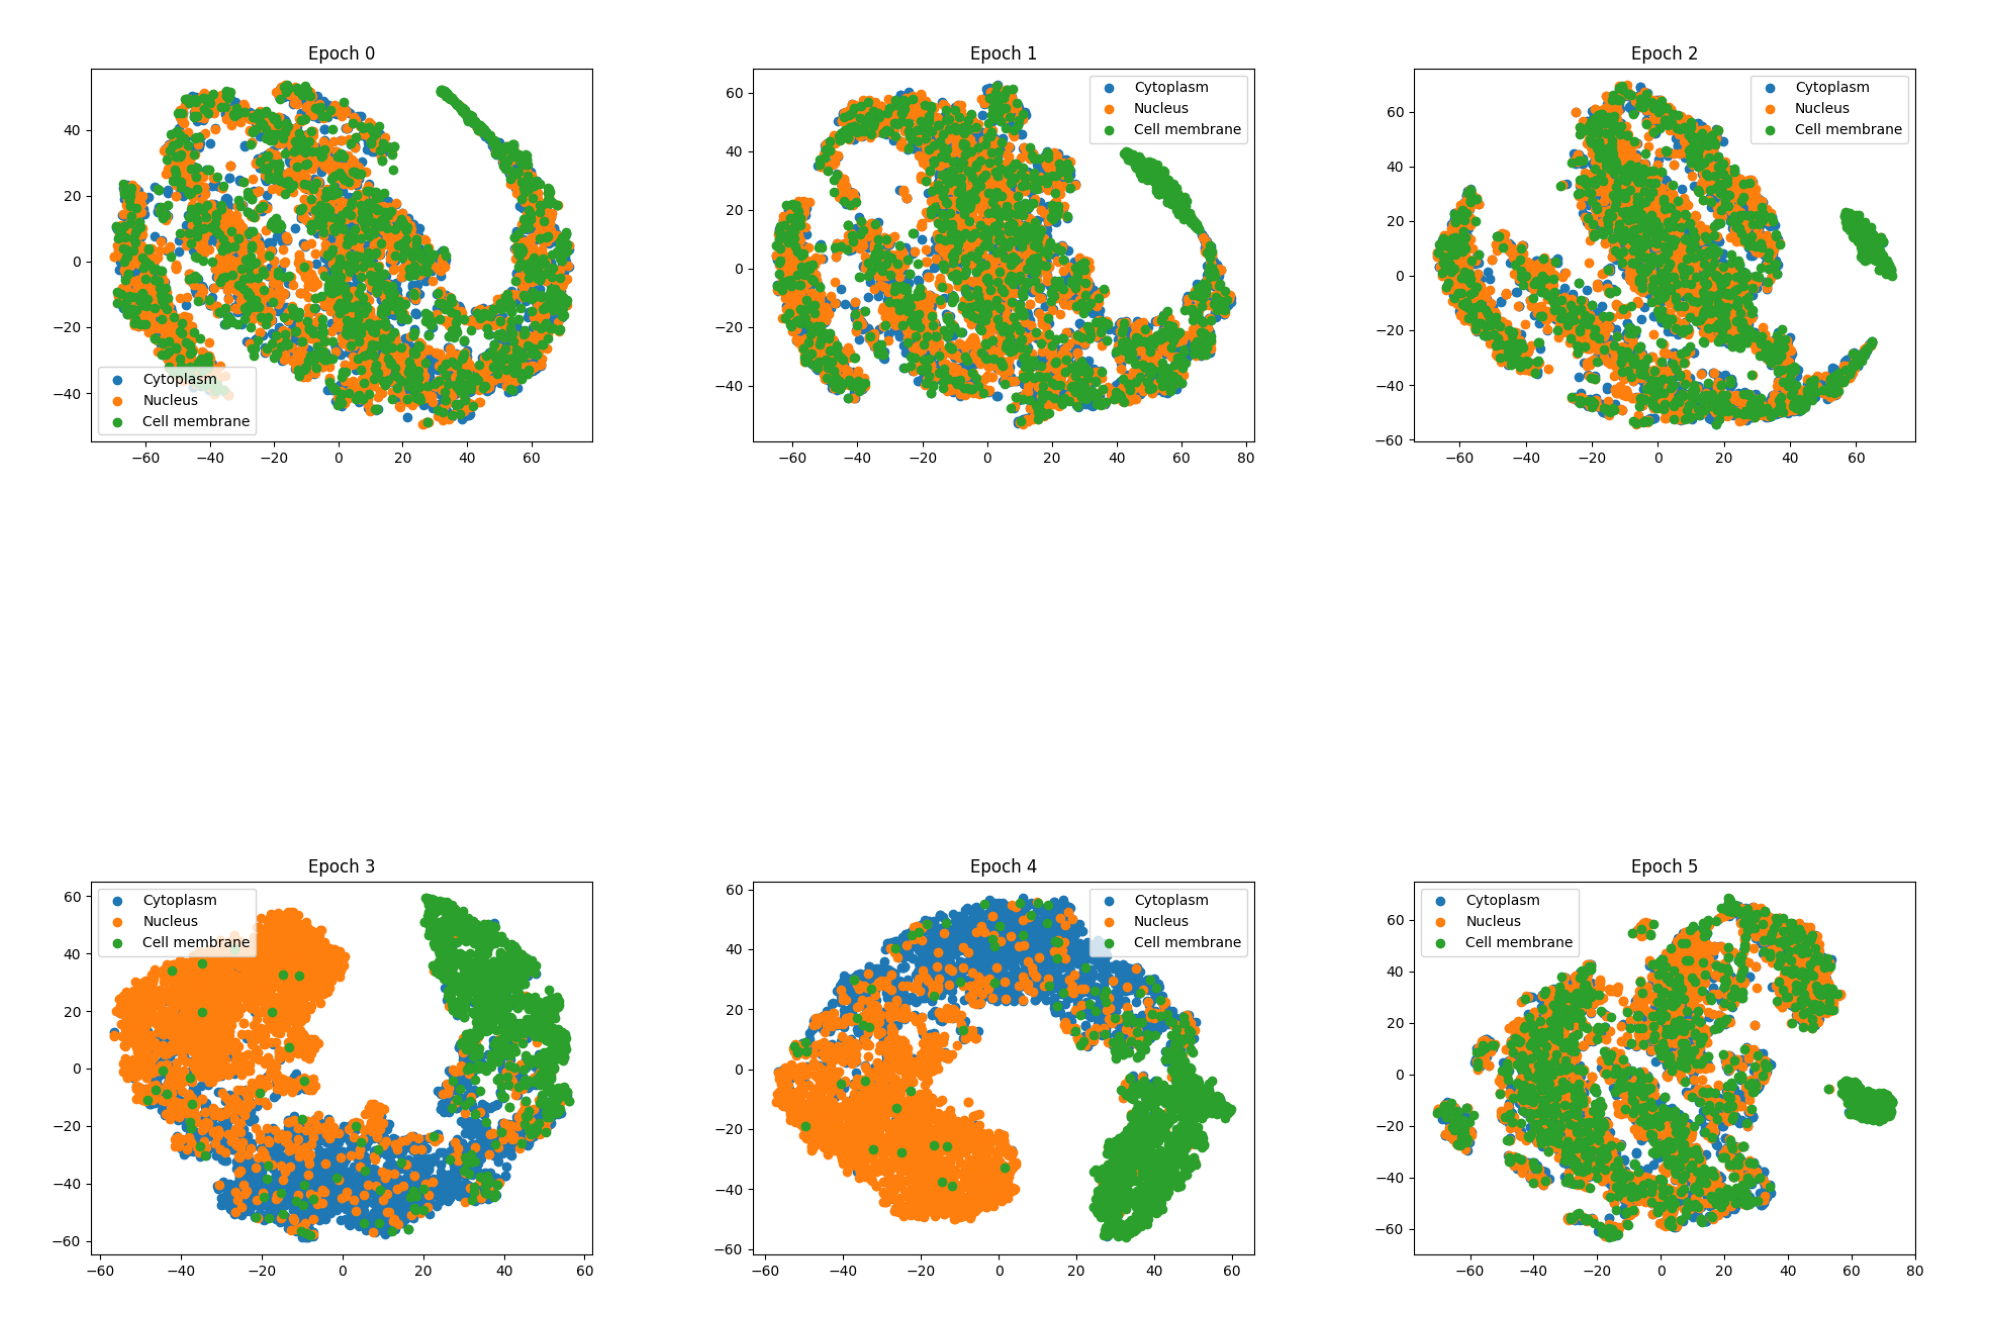

In [15]:
val_type = "train"
task = task_name
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/{task}/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

## Baseline [Subcell]: $Ensemble$

In [ ]:
with open("data/val_test_split.json", 'r') as json_file:
    dict_split = json.load(json_file)

val_genes = dict_split["val"]
test_genes = dict_split["test"]
final_preds = {ind:{0:0,1:0,2:0} for ind in test_genes}

names = [#"xlnet-base-cased",
#         "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract",
#         "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
#         "dmis-lab/biobert-base-cased-v1.1",
        "bert-base-cased",
#         "bert-base-uncased"
]



epochs = 5
lr = 1e-5
max_length = 512
batch_size = 20
pool ="cls"
drop_rate = 0.1
gene2vec_hidden = 200
device = "cuda"
class_map = class_map



for model_name in names:
    for gene2vec_flag in [True, False]:
        
        print(f"model :{model_name}, gene2vec: {gene2vec_flag}")
        
        if gene2vec_flag:
            task="sub_gene2vec"
        else:
            task="class"
        
        train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size,
                                                                 val_genes, test_genes,
                                                                 gene2vec_flag = gene2vec_flag,
                                                                 model_name = model_name)

        history, labels_test, best_pred = trainer(
                                                    epochs, gene_loaded_data, train_loader, val_loader, test_loader,
                                                    lr=lr, pool=pool, max_length=max_length, drop_rate=drop_rate,
                                                    gene2vec_flag=gene2vec_flag, gene2vec_hidden=gene2vec_hidden,
                                                    device=device, task_type=task_type, model_name=model_name,
                                                    task_name=task_name
                                                    )
        
        if gene2vec_flag:
            ind = test_loader.dataset.tensors[4]
        else:
            ind = test_loader.dataset.tensors[3]
            
            
        for i, pred in zip(ind, best_pred):
            final_preds[int(i)][int(pred)] += 1
        
with open("data/ensemble_preds_cls.json", 'w') as json_file:
    json.dump(final_preds, json_file)

labels_test2 = [int(i) for i in labels_test]
with open("data/true_labels_cls.json", 'w') as json_file:
    json.dump(labels_test2, json_file)



### Subcellular Locations Mean

In [ ]:
# Perform Majority Voting
y_pred = []
y_true = labels_test
for id_, class_counts in final_preds.items():
    majority_class = max(class_counts, key=class_counts.get)
    y_pred.append(majority_class)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')

print(f' Accuracy: {round(acc,4)}\n F1: {round(f1,4)}\n Precision: {round(prec,4)}\n Recall: {round(rec,4)}')
    
    

### Subcellular Locations CLS

In [ ]:
with open("data/ensemble_preds_cls.json") as json_file:
    final_preds = json.load(json_file)


with open("data/true_labels_cls.json") as json_file:
    labels_test = json.load(json_file)



y_pred = []
y_true = labels_test
for id_, class_counts in final_preds.items():
    majority_class = max(class_counts, key=class_counts.get)
    y_pred.append(int(majority_class))

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')

print(f' Accuracy: {round(acc,4)}\n F1: {round(f1,4)}\n Precision: {round(prec,4)}\n Recall: {round(rec,4)}')
    
    

# Solubility

In [ ]:

input_data_path = 'data/solubility.csv'
task_type = "classification"

gene_loaded_data, n_labels = loading_data(input_data_path, task_type)
print(f'Number of {task_name} labels: {n_labels}')
display(gene_loaded_data)





epochs =6
lr = 1e-5
pool ="cls"
max_length = 5
batch_size = 1000
drop_rate = 0.1
gene2vec_hidden = 200
gene2vec_flag = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task_type = task_type
n_labels = n_labels
task_name = task_name

model_name= "bert-base-cased"

train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size,
                                                     gene2vec_flag = gene2vec_flag,
                                                     model_name = model_name)

trainer(epochs, gene_loaded_data, train_loader, val_loader, test_loader,
            lr =lr, pool= pool, max_length= max_length, batch_size = batch_size, drop_rate =drop_rate,
            gene2vec_flag = gene2vec_flag, gene2vec_hidden = gene2vec_hidden, device = device,
            task_type = task_type, n_labels = n_labels, model_name= model_name, task_name = task_name)


## Solubility plot

In [ ]:
val_type = "train"
task = task_name
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/{task}/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

## Solubility Esemble

In [ ]:
with open("data/val_test_split.json", 'r') as json_file:
    dict_split = json.load(json_file)

val_genes = dict_split["val"]
test_genes = dict_split["test"]
final_preds = {ind:{0:0,1:0,2:0} for ind in test_genes}

names = [#"xlnet-base-cased",
#         "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract",
#         "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
#         "dmis-lab/biobert-base-cased-v1.1",
        "bert-base-cased",
#         "bert-base-uncased"
]



epochs = 5
lr = 1e-5
max_length = 512
batch_size = 20
pool ="cls"
drop_rate = 0.1
gene2vec_hidden = 200
device = "cuda"
class_map = class_map



for model_name in names:
    for gene2vec_flag in [True, False]:
        
        print(f"model :{model_name}, gene2vec: {gene2vec_flag}")
        
        if gene2vec_flag:
            task="sub_gene2vec"
        else:
            task="class"
        
        train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size,
                                                                 val_genes, test_genes,
                                                                 gene2vec_flag = gene2vec_flag,
                                                                 model_name = model_name)

        history, labels_test, best_pred = trainer(
                                                    epochs, gene_loaded_data, train_loader, val_loader, test_loader,
                                                    lr=lr, pool=pool, max_length=max_length, drop_rate=drop_rate,
                                                    gene2vec_flag=gene2vec_flag, gene2vec_hidden=gene2vec_hidden,
                                                    device=device, task_type=task_type, model_name=model_name,
                                                    task_name=task_name
                                                    )
        
        if gene2vec_flag:
            ind = test_loader.dataset.tensors[4]
        else:
            ind = test_loader.dataset.tensors[3]
            
            
        for i, pred in zip(ind, best_pred):
            final_preds[int(i)][int(pred)] += 1
        
with open("data/ensemble_preds_cls.json", 'w') as json_file:
    json.dump(final_preds, json_file)

labels_test2 = [int(i) for i in labels_test]
with open("data/true_labels_cls.json", 'w') as json_file:
    json.dump(labels_test2, json_file)



## Gene Expression

In [6]:

input_data_path = 'data/gene_expression.csv'
task_type = "regression"

gene_loaded_data, n_labels = loading_data(input_data_path, task_type)
print(f'Number of {task_name} labels: {n_labels}')
display(gene_loaded_data)





epochs =6
lr = 1e-5
pool ="cls"
max_length = 5
batch_size = 1000
drop_rate = 0.1
gene2vec_hidden = 200
gene2vec_flag = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task_type = task_type
n_labels = n_labels
task_name = task_name

model_name= "bert-base-cased"

train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size,
                                                     gene2vec_flag = gene2vec_flag,
                                                     model_name = model_name)

trainer(epochs, gene_loaded_data, train_loader, val_loader, test_loader,
            lr =lr, pool= pool, max_length= max_length, batch_size = batch_size, drop_rate =drop_rate,
            gene2vec_flag = gene2vec_flag, gene2vec_hidden = gene2vec_hidden, device = device,
            task_type = task_type, n_labels = n_labels, model_name= model_name, task_name = task_name)


Number of gene_expression labels: 1


,Gene name,Summary,Interactions,Label
0,FES,This gene encodes the human cellular counterpa...,Homooligomer.Interacts with BCR.Interacts (whe...,1.223158
1,SLC7A7,The protein encoded by this gene is the light ...,NaN,1.646245
2,HSPA2,Enables disordered domain specific binding act...,NaN,2.462888
3,ZSCAN9,Enables sequence-specific double-stranded DNA ...,NaN,3.455762
4,SEPTIN3,This gene encodes a member of the sorting nexi...,Interacts with ATP6V1D; may play a role in cil...,1.506968
...,...,...,...,...
15392,IQCJ-SCHIP1,C19orf25 (Chromosome 19 Open Reading Frame 25)...,NaN,3.268573
15393,BPY2C,This gene is located in the nonrecombining por...,Interacts with MAP1S.Interacts with UBE3A (via...,0.000739
15394,DNER,The protein encoded by this gene is a cofactor...,Forms a 1:1 stoichiometric complex with pancre...,1.579729
15395,SOX7,Predicted to enable Notch binding activity. In...,Interacts with AP1G1.Interacts with NOTCH1 (By...,1.060241


Shape of tokens_df before gene2vec:(15397, 6)
Shape of tokens_df after gene2vec:(15397, 6)

###############################
Currently running gene_expression.
###############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.72it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.09it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.45it/s]


	ET: 16.71 Seconds
	Train Loss: 8.6451, corrcoef: 0.016
	Val Loss: 5.7997, corrcoef: 0.0932
	Test Loss: 5.6221, corrcoef: 0.0323
Epoch 2 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.86it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.84it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.31it/s]


	ET: 16.45 Seconds
	Train Loss: 5.6335, corrcoef: 0.0693
	Val Loss: 4.9711, corrcoef: 0.1443
	Test Loss: 4.9366, corrcoef: 0.1028
Epoch 3 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.52it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.84it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.02it/s]


	ET: 16.52 Seconds
	Train Loss: 5.1995, corrcoef: 0.1376
	Val Loss: 4.9358, corrcoef: 0.1683
	Test Loss: 4.9015, corrcoef: 0.2019
Epoch 4 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.52it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.45it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.88it/s]


	ET: 17.76 Seconds
	Train Loss: 5.1761, corrcoef: 0.1728
	Val Loss: 4.8823, corrcoef: 0.2144
	Test Loss: 4.8471, corrcoef: 0.2279
Epoch 5 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.82it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.65it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.54it/s]


	ET: 16.64 Seconds
	Train Loss: 5.2425, corrcoef: 0.1762
	Val Loss: 4.8469, corrcoef: 0.1922
	Test Loss: 4.7709, corrcoef: 0.2027
Epoch 6 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.87it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.58it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.36it/s]


	ET: 16.43 Seconds
	Train Loss: 5.0847, corrcoef: 0.2121
	Val Loss: 4.8251, corrcoef: 0.2165
	Test Loss: 4.7615, corrcoef: 0.2262


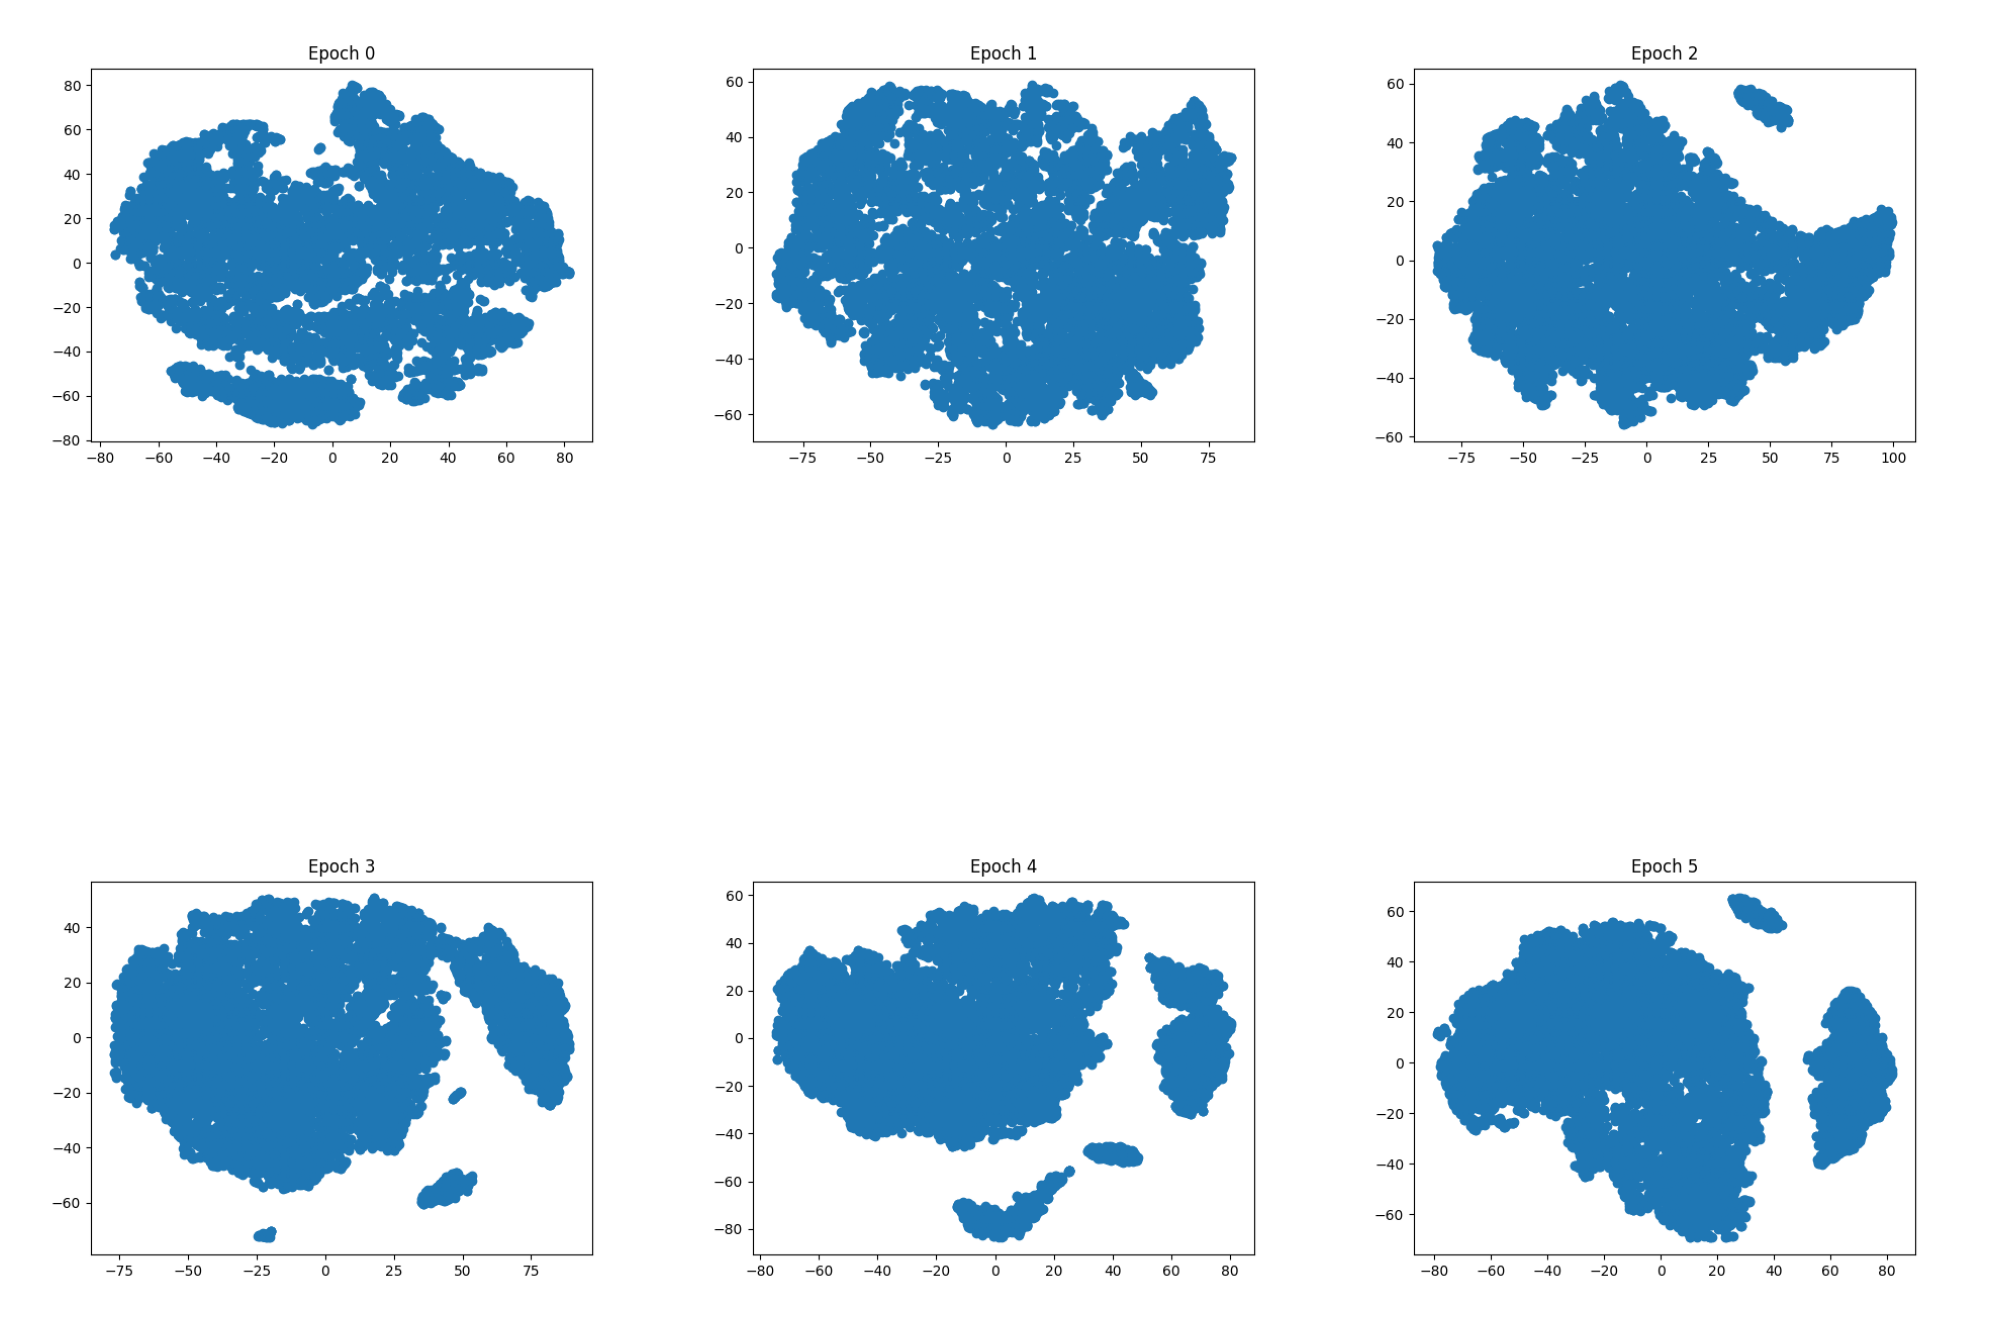

In [7]:
val_type = "train"
task = task_name
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/{task}/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

In [10]:
with open("data/val_test_split.json", 'r') as json_file:
    dict_split = json.load(json_file)

val_genes = dict_split["val"]
test_genes = dict_split["test"]
final_preds = {ind:{0:0,1:0,2:0} for ind in test_genes}

names = [#"xlnet-base-cased",
#         "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract",
#         "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
#         "dmis-lab/biobert-base-cased-v1.1",
        "bert-base-cased",
#         "bert-base-uncased"
]



epochs = 5
lr = 1e-5
max_length = 512
batch_size = 20
pool ="cls"
drop_rate = 0.1
gene2vec_hidden = 200
device = "cuda"
class_map = class_map



for model_name in names:
    for gene2vec_flag in [True, False]:
        
        print(f"model :{model_name}, gene2vec: {gene2vec_flag}")
        
        if gene2vec_flag:
            task="sub_gene2vec"
        else:
            task="class"
        
        train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size,
                                                                 val_genes, test_genes,
                                                                 gene2vec_flag = gene2vec_flag,
                                                                 model_name = model_name)

        history, labels_test, best_pred = trainer(
                                                    epochs, gene_loaded_data, train_loader, val_loader, test_loader,
                                                    lr=lr, pool=pool, max_length=max_length, drop_rate=drop_rate,
                                                    gene2vec_flag=gene2vec_flag, gene2vec_hidden=gene2vec_hidden,
                                                    device=device, task_type=task_type, model_name=model_name,
                                                    task_name=task_name
                                                    )
        
        if gene2vec_flag:
            ind = test_loader.dataset.tensors[4]
        else:
            ind = test_loader.dataset.tensors[3]
            
            
        for i, pred in zip(ind, best_pred):
            final_preds[int(i)][int(pred)] += 1
        
with open("data/ensemble_preds_cls.json", 'w') as json_file:
    json.dump(final_preds, json_file)

labels_test2 = [int(i) for i in labels_test]
with open("data/true_labels_cls.json", 'w') as json_file:
    json.dump(labels_test2, json_file)



model :bert-base-cased, gene2vec: True
Shape of tokens_df before gene2vec:(15397, 6)
Adding Gene2Vec data ...
Shape of tokens_df after gene2vec:(13978, 7)


KeyError: '[2775, 3398, 5928, 8493, 1281, 982, 6963, 608, 162, 1635, 3497, 5169, 4756, 5614, 5612, 237, 3310, 5803, 31, 1375, 6329, 2954, 4663, 2004, 112, 3131, 4592, 4273, 5660, 194, 3931, 2069, 3461, 7823, 3517, 2888, 717, 1175, 5204, 3815, 2195, 341, 800, 1273, 5850, 1128, 990, 3453, 5625, 2763, 417, 3285, 8204, 7996, 4327, 4136, 4719, 3047, 3314, 5913, 2421, 3567, 6398, 8293, 5952, 436, 3003, 6070, 1625, 5321, 1339, 2789, 5164, 6224, 1327, 6726, 7254, 7081, 2929, 1264, 6395, 318, 219, 6295, 4857, 5933, 7782, 4510, 1910, 2847, 5528, 8157, 2570, 6406, 1492, 2885, 4954, 2253, 3538, 3171, 2527, 2512, 6735] not in index'

### Word distribution

In [ ]:

num_words_per_sentence =[]

for summary in genes["Summary"]:
    for sent in sent_tokenize(summary):
        num_words_per_sentence.append(len(sent.split()))
        

num_sent_per_sentence = [len(sent_tokenize(sentence)) for sentence in genes["Summary"]]

plt.hist(num_words_per_sentence)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Sentences')
plt.show()